In [134]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
matplotlib.rcParams['figure.figsize'] = [15, 5]


In [119]:
df = pd.read_csv('Documents/Seafile/Covid-19 data/FRM_SPX_Time_Series_FRM_19862020.csv',
                 delim_whitespace = True, names = ['Lambda'], parse_dates=True)


In [258]:
df1987 = df['1987-08-01':'1988-06-01']
df2007 = df['2007-01-01':'2010-12-12']


In [285]:
def logistic_function(t, N_0, K, r):
    N_t = N_0*np.exp(r*t)/(1+(N_0/K)*(np.exp(r*t)-1))
    return N_t

def hubbert_curve(t, N_0, K, r):
    nominator = np.exp(r*t)*N_0*(K-N_0)
    denominator = K*((1+(N_0/K)*(np.exp(r*t)-1))**2)
    return nominator/denominator

def three_hubbert_curve(t, N_0_1, K_1, r_1, N_0_2, K_2, r_2, N_0_3, K_3, r_3):
    return three_hubbert_curve(t, N_0=N_0_1, K=K_1, r=r_1) + hubbert_curve(t, N_0=N_0_2, K=K_2,r=r_2) + hubbert_curve(t, N_0=N_0_3, K=K_3, r=r_3)

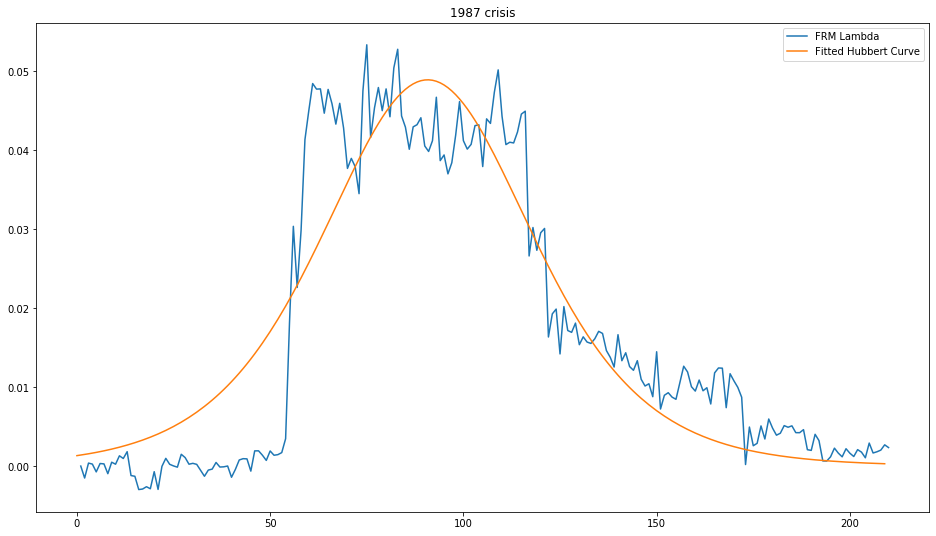

In [257]:
y = df1987.Lambda - df1987.Lambda.iloc[0]
x = np.arange(len(y))+1
(N_0, K, r), cov = opt.curve_fit(hubbert_curve, x[1:], y[1:], p0 = (0, 0.1, 0.1), bounds = ([-1,0,0], [100,100,100]))

plt.figure(figsize=(16,9))
plt.title("1987 crisis")
plt.plot(x,y, label = 'FRM Lambda')
plt.plot(hubbert_curve(t = x, N_0 = N_0, K = K, r =r), label = 'Fitted Hubbert Curve')
plt.legend()

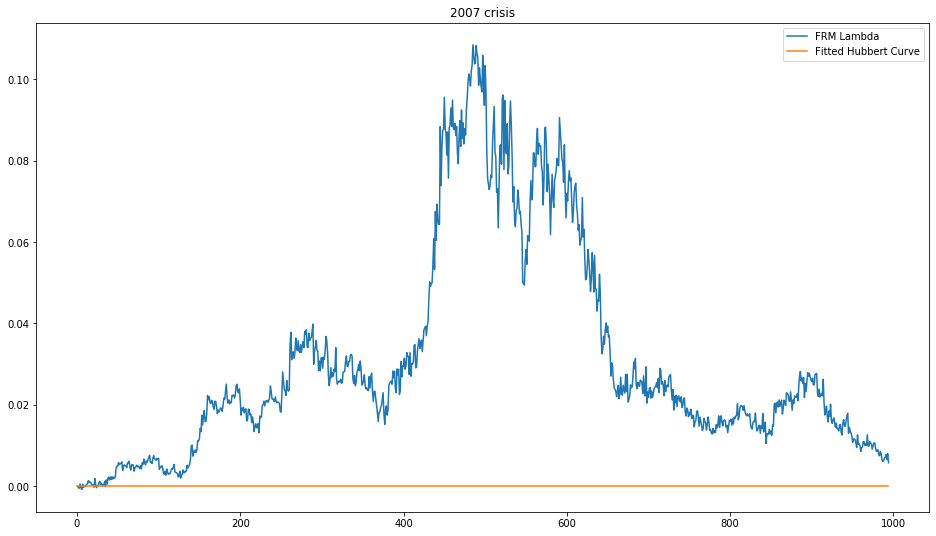

In [292]:
y = df2007.Lambda - df2007.Lambda.iloc[0]
x = np.arange(len(y))+1
(N_0, K, r), cov = opt.curve_fit(logistic_function, x[1:], y[1:], p0 = (0, 30, 0.1), bounds = ([-1,0,0], [100,100,100]))


plt.figure(figsize=(16,9))
plt.title("2007 crisis")
plt.plot(x, y, label = 'FRM Lambda')
plt.plot(hubbert_curve(t = x, N_0 = N_0, K = K, r =r), label = 'Fitted Hubbert Curve')
plt.legend()

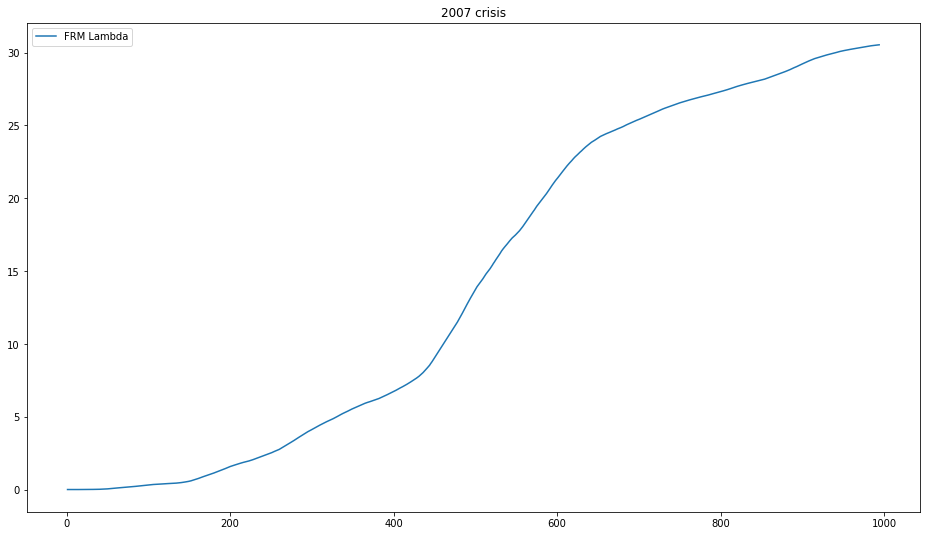

In [300]:
y = df2007.Lambda - df2007.Lambda.iloc[0]
x = np.arange(len(y))+1
(N_0, K, r), cov = opt.curve_fit(logistic_function, x[1:], y[1:].cumsum(), p0 = (0,10, 0.1), bounds = ([-1,0,0], [100,100,100]))


plt.figure(figsize=(16,9))
plt.title("2007 crisis")
plt.plot(x, y.cumsum(), label = 'FRM Lambda')
#plt.plot(hubbert_curve(t = x, N_0 = N_0, K = K, r =r), label = 'Fitted Hubbert Curve')
plt.legend()